In [2]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

In [3]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 2


In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.2 MB/s eta 0:00:00a 0:00:01


In [5]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.5
    Uninstalling ipywidgets-8.1.5:
      Successfully uninstalled ipywidgets-8.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
bigframes 2.26.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.


In [6]:
dataset_path = '/kaggle/input/car-plate-detection'

In [7]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Searching for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)
    
    # If a match is found, returning the matched number as an integer
    if match:
        return int(match.group(0))
    else:
        return 0

print(the_number_in_the_string("Cars105.png")) 

105


In [8]:
labels_dict = dict(
    img_path=[], 
    x_min=[], 
    x_max=[], 
    y_min=[], 
    y_max=[], 
    img_w=[], 
    img_h=[]
)

xml_files = glob(f'{dataset_path}/annotations/*.xml')

for filename in sorted(xml_files, key=the_number_in_the_string):
    
    info = xet.parse(filename)
    root = info.getroot()
    
    # Finding the 'object' element in the XML and extracting bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    x_min = int(labels_info.find('xmin').text)
    x_max = int(labels_info.find('xmax').text)
    y_min = int(labels_info.find('ymin').text)
    y_max = int(labels_info.find('ymax').text)

    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    labels_dict['img_path'].append(img_path)
    labels_dict['x_min'].append(x_min)
    labels_dict['x_max'].append(x_max)
    labels_dict['y_min'].append(y_min)
    labels_dict['y_max'].append(y_max)
    
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
all_data = pd.DataFrame(labels_dict)

all_data.head()

,img_path,x_min,x_max,y_min,y_max,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350


In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(all_data, test_size=1/10, random_state=42)

train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')


      len(train) = 345
      len(val) = 44
      len(test) = 44



In [10]:
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [11]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['x_min'] + row['x_max']) / 2 / row['img_w']
        y_center = (row['y_min'] + row['y_max']) / 2 / row['img_h']
        width = (row['x_max'] - row['x_min']) / row['img_w']
        height = (row['y_max'] - row['y_min']) / row['img_h']

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [12]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


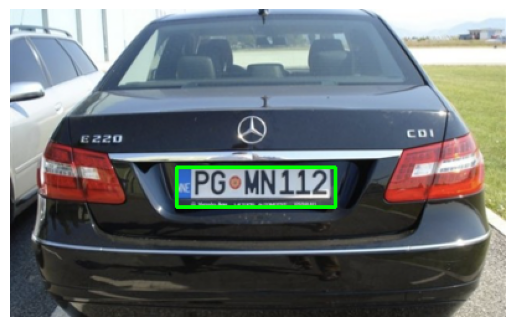

In [13]:
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open(label_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(image)
plt.axis('off') 
plt.show() 

In [20]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [15]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [16]:
model_yolo = YOLO('yolov8n.pt')

In [22]:
model_yolo.train(
    data = '/kaggle/working/datasets.yaml',
    epochs = 120,
    batch = 64,
    device = 'cuda',
    imgsz = 320,
    cache = True
)

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/datasets.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dd2ce5861e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

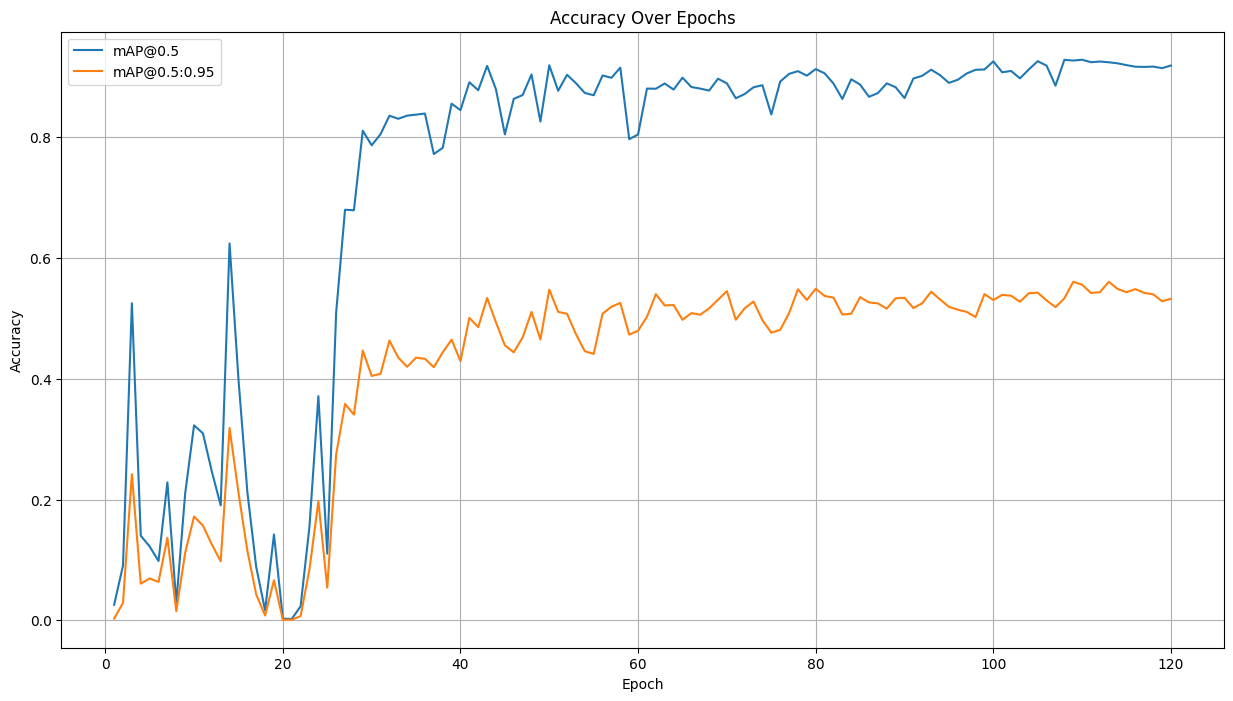

In [23]:
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  

epochs = results.index + 1  
mAP_0_5 = results['metrics/mAP50(B)']  
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  

plt.figure(figsize=(15, 8))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
model_yolo.save('best_license_plate_model.pt')

In [25]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """

    results = model_yolo.predict(path_test_car, device='cpu')

    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for result in results:
        for box in result.boxes:
           
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    plt.imshow(image)
    plt.axis('off') 
    plt.show() 


image 1/1 /kaggle/input/car-plate-detection/images/Cars253.png: 192x320 1 license_plate, 58.8ms
Speed: 0.9ms preprocess, 58.8ms inference, 9.7ms postprocess per image at shape (1, 3, 192, 320)


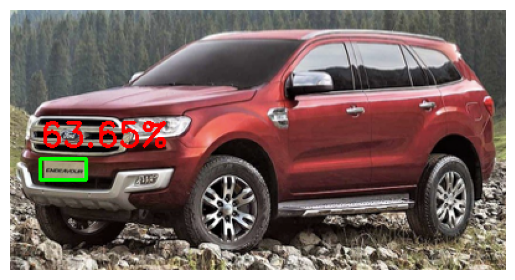

In [26]:
predict_and_plot(test.iloc[6].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars415.png: 256x320 1 license_plate, 58.4ms
Speed: 0.9ms preprocess, 58.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


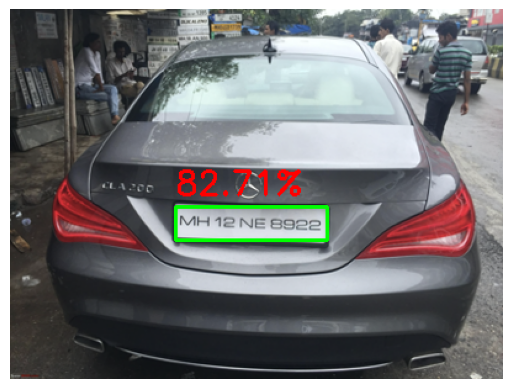

In [27]:
predict_and_plot(test.iloc[9].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars364.png: 224x320 1 license_plate, 54.1ms
Speed: 0.8ms preprocess, 54.1ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


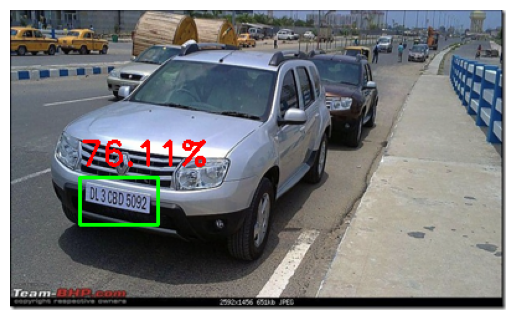

In [28]:
predict_and_plot(test.iloc[4].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 46.2ms
Speed: 1.1ms preprocess, 46.2ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 192)


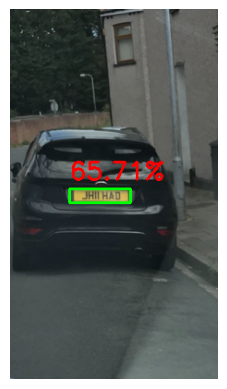

In [29]:
predict_and_plot(test.iloc[2].img_path)

In [30]:
!pip install pytesseract

In [32]:
import pytesseract
from pytesseract import Output

In [34]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """

    results = model_yolo.predict(path_test_car, device='cpu')

    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for result in results:
        for box in result.boxes:
           
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            
            # Croping the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]
            
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected plate number: {text}")

    plt.imshow(image)
    plt.axis('off') 
    plt.show() 


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 47.8ms
Speed: 0.8ms preprocess, 47.8ms inference, 0.8ms postprocess per image at shape (1, 3, 160, 320)
Detected plate number: G526 JHD



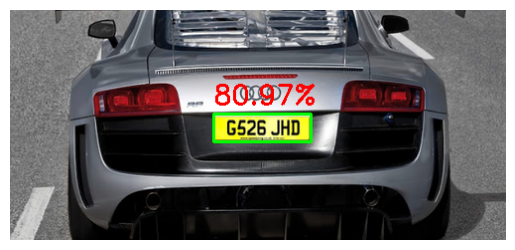

In [38]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 32.6ms
Speed: 0.8ms preprocess, 32.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 192)
Detected plate number: { JHTHAD |



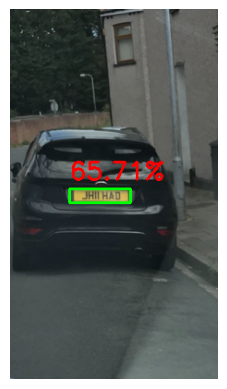

In [39]:
predict_and_plot(test.iloc[2].img_path)